In [1]:
import numpy as np
from spec_id import Stack_model, Stack_spec, Model_fit_stack,Analyze_Stack_avgage,Analyze_Stack,Likelihood_contours, Gauss_dist, Make_model_list,\
    Stack_spec_normwmean,Stack_model_normwmean, Model_fit_stack_normwmean_flxerr
import matplotlib.pyplot as plt
from vtl.Readfile import Readfile
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d
import os
import cPickle
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [2]:
ids,speclist,lmass,rshift,rad,sig,comp=np.array(Readfile('masslist_mar22.dat',is_float=False))
lmass,rshift,rad,sig,comp=np.array([lmass,rshift,rad,sig,comp]).astype(float)

IDc=[]  # compact sample
IDd=[]  # diffuse sample

IDmL=[]  # low mass sample
IDmH=[]  # high mass sample

for i in range(len(ids)):
    if 0.11 < comp[i]:
        IDd.append(i)
    if 0.11 > comp[i]:
        IDc.append(i)
    if 10.931 > lmass[i]:
        IDmL.append(i)
    if 10.931 < lmass[i]:
        IDmH.append(i)

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

print len(IDc)
print len(IDd)

print len(IDmH)
print len(IDmL)

10
15
6
19


In [4]:
window=[3100,5400]

wv,fl,er=Stack_spec_normwmean(speclist[IDc],rshift[IDc],np.arange(window[0],window[1],10))

residuals=[]
for i in range(len(metal)):
    for ii in range(len(age)):
        flistH=Make_model_list(ids[IDc],metal[i],age[ii],0,rshift[IDc])
        mwv,mfl=Stack_model_normwmean(speclist[IDc],flistH, rshift[IDc], np.arange(wv[0],wv[-1]+10,10))
        residuals.append(fl-mfl)
res=np.transpose(residuals)

print sum(res)

[ 0.2289276   0.22851349  0.23108501 ..., -0.05144467 -0.05253767
 -0.05365474]


401.525807611
248.220892238
------
0.237817438516
1.01126857785


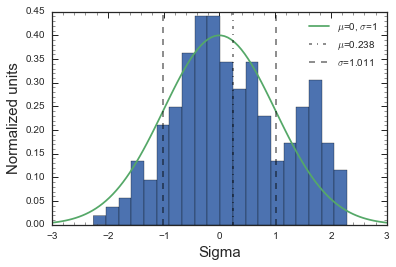

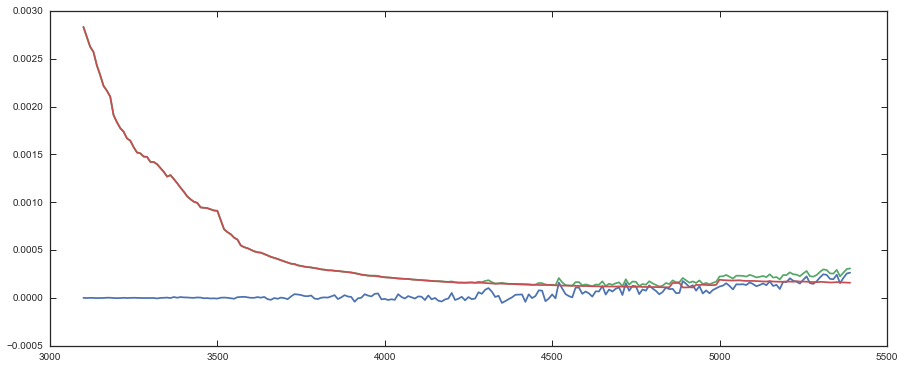

In [11]:
%matplotlib inline

#0.0096, 1.85, 0.0 low mass best fit

flistH=Make_model_list(ids[IDc],0.014, 3.3, 0,rshift[IDc])
mwv,mfl=Stack_model_normwmean(speclist[IDc],flistH, rshift[IDc], np.arange(wv[0],wv[-1]+10,10))

mpwave=np.array([np.mean(U) for U in res])

wmpwave=(np.array(mpwave)/er**2)/1.5E8

# mer=np.sqrt(er**2+(mpwave)**2)
wmer=np.sqrt(er**2+(wmpwave)**2)

print np.sum(((fl-mfl)/er)**2)
# print np.sum(((fl-mfl)/mer)**2)
print np.sum(((fl-mfl)/wmer)**2)

# sres=(fl-mfl)/mer
wsres=(fl-mfl)/wmer

# print '______'
# print np.mean(sres)
# print np.std(sres)
print '------'
print np.mean(wsres)
print np.std(wsres)

rng=np.linspace(-3,3,100)
plt.hist(wsres,20,normed=True)
plt.plot(rng,Gauss_dist(rng,0,1),label='$\mu$=0, $\sigma$=1')
plt.axvline(np.mean(wsres),color='k',alpha=.5,linestyle='-.',label='$\mu$=%0.3f' % np.mean(wsres))
plt.axvline(np.std(wsres),color='k',alpha=.5,linestyle='--',label='$\sigma$=%0.3f' % np.std(wsres))
plt.axvline(-np.std(wsres),color='k',alpha=.5,linestyle='--')
plt.xlabel('Sigma',size=15)
plt.ylabel('Normalized units',size=15)
plt.legend()
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=10)
plt.gcf().subplots_adjust(bottom=0.16)
plt.show()


plt.figure(figsize=[15,6])
# plt.errorbar(wv,fl,wmer,fmt='o')
# plt.plot(wv,fl)
# plt.plot(wv,interp1d(mwv,mfl)(wv))
# plt.plot(mwv,mfl/fl)
plt.plot(wv,wmpwave)
plt.plot(wv,wmer)
plt.plot(wv,er)
plt.show()

# flxdat=Table([wv,wmpwave],names=('wv','model_error'))
# ascii.write(flxdat,'flx_err/lt10.93_mar17.dat')

In [27]:
%matplotlib inline
dat=fits.open('chidat/lmass_mar7_nt_fit_chidata.fits')

chi = []
for i in range(len(metal)):
    chi.append(dat[i + 1].data)
chi = np.array(chi)

dchi=chi-np.min(chi)

IDC=np.argwhere(dchi<=10)

sres=[]
for i in range(len(IDC)):
    mlist=Make_model_list(ids,metal[IDC[i][0]],age[IDC[i][1]],tau[IDC[i][2]],rshift)
    Mwv,Mfl=Stack_model_normwmean(speclist,mlist,rshift,np.arange(wv[0],wv[-1]+10,10))
    sres.append((fl-Mfl/er))

Tsres=np.transpose(sres)
msres=np.zeros(len(Tsres))
for i in range(len(Tsres)):
    msres[i]=np.abs(np.mean(Tsres[i]))

-0.541755972031
1.02324872001


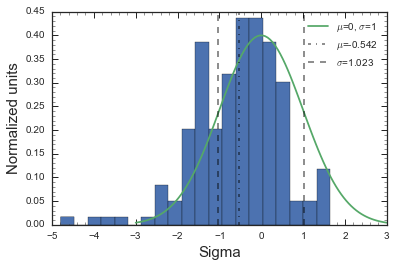

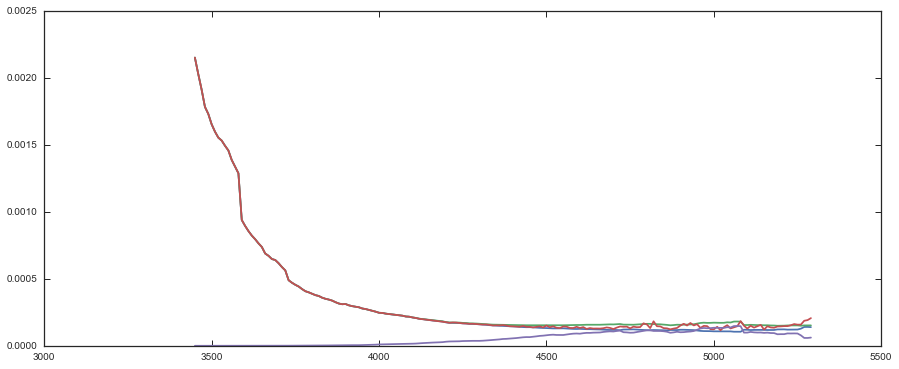

In [35]:
# flxerror=msres/640000
flxerror=(msres/er**2)/3E13
error=np.sqrt(er**2+(flxerror)**2)

nsr=(fl-mfl)/error

print np.mean(nsr)
print np.std(nsr)

rng=np.linspace(-3,3,100)
plt.hist(nsr,20,normed=True)
plt.plot(rng,Gauss_dist(rng,0,1),label='$\mu$=0, $\sigma$=1')
plt.axvline(np.mean(nsr),color='k',alpha=.5,linestyle='-.',label='$\mu$=%0.3f' % np.mean(nsr))
plt.axvline(np.std(nsr),color='k',alpha=.5,linestyle='--',label='$\sigma$=%0.3f' % np.std(nsr))
plt.axvline(-np.std(nsr),color='k',alpha=.5,linestyle='--')
plt.xlabel('Sigma',size=15)
plt.ylabel('Normalized units',size=15)
plt.legend()
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=10)
plt.gcf().subplots_adjust(bottom=0.16)
plt.show()

plt.figure(figsize=[15,6])
# plt.plot(wv,fl)
plt.plot(wv,er)
plt.plot(wv,error)
plt.plot(wv,wmer)
plt.plot(wv,flxerror)
plt.show()

# flxdat=Table([wv,flxerror],names=('wv','model_error'))
# ascii.write(flxdat,'flx_err/LM_%s-%s.dat' % (window[0],window[1]))

146.527345159


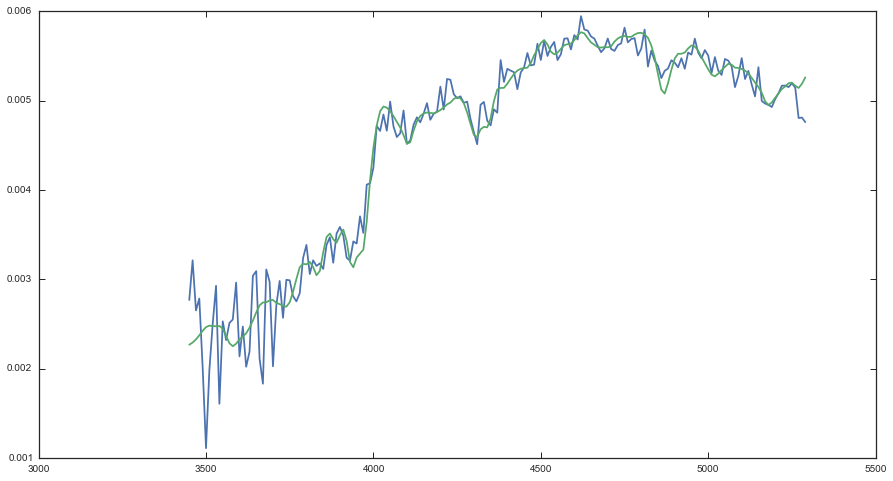

In [44]:
flistH=Make_model_list(ids,0.019, 1.3, 0,rshift)
mwv,mfl=Stack_model_normwmean(speclist,flistH, rshift, np.arange(wv[0],wv[-1]+10,10))

print sum(((fl-mfl)/er)**2)

# flistH=Make_model_list(ids,0.0132, 1.7, 0,rshift)
# mwv,mfl=Stack_model_normwmean(speclist,flistH, rshift, np.arange(wv[0],wv[-1]+10,10))
# 
# print sum(((fl-mfl)/er)**2)

plt.figure(figsize=[15,8])
plt.plot(wv,fl)
plt.plot(mwv,mfl)
plt.show()
plt.close()